## Evolution Strategies

![img](https://t4.ftcdn.net/jpg/00/17/46/81/240_F_17468143_wY3hsHyfNYoMdG9BlC56HI4JA7pNu63h.jpg)

[The paper about the algorithm](https://arxiv.org/abs/1703.03864)

Plan:
* Study how to use OpenAI gym
* Basic prototype of evolutionary strategies that works in one thread on CartPole
* Modify the code to make them work in parallel
* Use the algorithm to solve the LunarLander
* Analyse the influence of hyperparameters

In [56]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [57]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import time
from copy import deepcopy
from joblib import Parallel, delayed
from IPython.display import clear_output
from IPython import display
 
%matplotlib inline

# OpenAI gym environment

/mnt/sdb1/home/l.morozov/Practical_RL/venv/lib/python3.8/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space: Discrete(2)


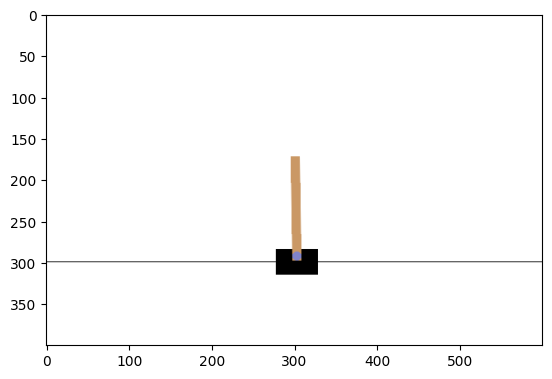

In [58]:
import gym

tmp_env = gym.make("CartPole-v0", render_mode='rgb_array')
tmp_env.reset()

plt.imshow(tmp_env.render())
print("Observation space:", tmp_env.observation_space)
print("Action space:", tmp_env.action_space)
state_size = tmp_env.observation_space.shape[0]
n_actions = tmp_env.action_space.n

### How to interact with the environment

In [59]:
print("Initial observation:", tmp_env.reset())

new_s, reward, done, _, _ = tmp_env.step(0)
print("At each step it returns:")

print("new observation code:", new_s)
print("reward:", reward)
print("is game over?:", done)

Initial observation: (array([-0.0069603 ,  0.0288543 ,  0.04521049, -0.0428486 ], dtype=float32), {})
At each step it returns:
new observation code: [-0.00638321 -0.16688582  0.04435351  0.2637489 ]
reward: 1.0
is game over?: False


/mnt/sdb1/home/l.morozov/Practical_RL/venv/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


### Display an episode

In [60]:
def display_session(env, agent, t_max=500):
    total_reward = 0
    plt.figure(figsize=(4, 3))
    display.clear_output(wait=True)

    s = env.reset()[0]
    
    for t in range(t_max):
        plt.gca().clear()
        
        a = agent.get_action(torch.tensor(s).float())
        new_s, r, done, info, _ = env.step(a)
        s = new_s
        total_reward += r
        # Draw game image on display.
        plt.imshow(env.render())

        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        if done:
            print("Done!")
            break
            
    return total_reward

### Random policy

In [61]:
import numpy as np
class RandomPolicy:
    def __init__(self, n_actions) -> None:
        self.n_actions = n_actions
    
    def get_action(self, state):
        return np.random.choice(np.arange(self.n_actions))

Done!
Total reward:  64.0


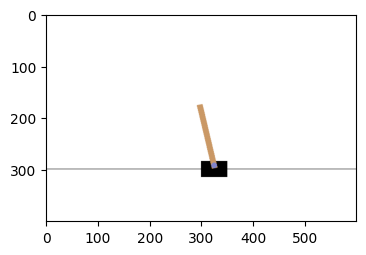

In [72]:
total_reward = display_session(tmp_env, RandomPolicy(n_actions), t_max=10000)
print('Total reward: ', total_reward)

# The challenge of the day

![Algorithm](https://i.ibb.co/zFm6BrB/Screenshot-from-2021-09-17-13-38-00.png)

Idea: pose a RL problem as a black-box optimization (policy's parameters affect the reward)

1. Sample a point from the domain
2. update parameters according to each pertrubation's impact on the reward

FAQ:

1. Why exactly do we **add** something to a parameter?
2. Why aren't coefficients $F_i$ normalized to be a convex combination?

    They coulb be of a very different scale. It should be transformed to a relative scaled, shouldn't it be?
    This notebook supports this.

3. How do we know when to stop?
4. How does this compare to CE method?

### Model evaluation

In [63]:
def generate_session(env, agent, t_max=500):
    total_reward = 0
    s = env.reset()[0]
    
    for t in range(t_max):
        a = agent.get_action(torch.tensor(s).float())
        new_s, r, done, info, _ = env.step(a)
        total_reward += r
        s = new_s
        
        if done:
            break
            
    return total_reward


def score(env, agent, n=10, t_max=500):
    """We estimate the mean of the total reward of our policy (agent)

    Args:
        env (_type_): _description_
        agent (_type_): _description_
        n (int, optional): _description_. Defaults to 10.
        t_max (int, optional): _description_. Defaults to 500.

    Returns:
        _type_: _description_
    """
    sample_rewards = [generate_session(env, agent, t_max=t_max) for _ in range(n)]
    return np.mean(sample_rewards)

### Modification of the model using a noise 

In [64]:
from copy import deepcopy
def add_noise_to_model(model, noise, copy=False):
    if copy:
        model = deepcopy(model)
    with torch.no_grad():
        for param in model.parameters():
            param.add_(noise)
    return model

#### Task 2: Implement a neural network-based policy

### Neural policy

In [73]:
class MLPPolicy(nn.Module):
    def __init__(self, n_states, n_actions, hidden_size = 40, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.mlp = nn.Sequential(
            nn.Linear(n_states, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )
    
    def get_action(self, state) -> int:
        # convert to tensors??
        with torch.no_grad():
            logits = self.forward(state)
        probs = logits.softmax(dim=-1).numpy()
        return probs.argmax(axis=-1)
    
    def forward(self, X):
        return self.mlp(X)

In [74]:
m = MLPPolicy(2, 5)
copied = deepcopy(list(m.parameters()))
assert torch.all(copied[0] == list(m.parameters())[0])
m = add_noise_to_model(m, torch.tensor(1))
assert not torch.all(copied[0] == list(m.parameters())[0])
#
m = MLPPolicy(2, 5)
copied = deepcopy(list(m.parameters()))
m2 = add_noise_to_model(m, torch.tensor(1), copy=True)
assert torch.all(copied[0] == list(m.parameters())[0])
assert not torch.all(copied[0] == list(m2.parameters())[0])

### Controller of the evolution

#### Task 1: Implement the algorithm

In [79]:
class EvolutionManager:
    def __init__(self, get_env_function, model, lr=0.001, std=0.01, n_samples = 64, normalize=True):
        super().__init__()
        
        self.lr = lr
        self.std = std
        self.normalize = normalize
        self.n_samples = n_samples
        self.mean_reward_history = []
        
        self.env = get_env_function()
        #
        self.model = model
        
    def get_noised_model(self):
        pass

    def optimize(self, noises: np.array, rewards: np.array):
        if self.normalize:
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
        to_add = np.sum(noises * rewards) / (self.n_samples * self.std) * self.lr
        with torch.no_grad():
            for param in self.model.parameters():
                param.add_(to_add)

    def _score(self, agent, t_max=10000):
        return score(env=self.env, agent=agent, t_max=t_max)

    def step(self):
        noises: np.array = np.random.normal(size=(self.n_samples))
        rewards: list = []
        for noise in noises:
            noised_model = add_noise_to_model(
                self.model, 
                noise=self.std * noise, 
                copy=True
            )
            # assess the noised policy generating an entire sample of sessions from it
            # NOTE: This is the bottleneck. It can definetely be parallelized.
            mean_reward = self._score(agent=noised_model, t_max=10000)
            rewards.append(mean_reward)
        rewards = np.array(rewards)
        self.optimize(noises, rewards)
        self.update_log(rewards)
        
    def update_log(self, rewards):
        mean_reward = np.mean(rewards)
        self.mean_reward_history.append(mean_reward)

        clear_output(True)
        print("last mean reward = %.3f" % mean_reward)
        plt.figure(figsize=[8, 4])
        plt.subplot(1, 2, 1)
        plt.plot(self.mean_reward_history, label='Mean rewards')
        plt.legend()
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.hist(rewards)
        plt.grid()

        plt.show()
    

### Environment 1: CartPole-v0

In [80]:
def get_env_function():
    env = gym.make('CartPole-v0', render_mode="rgb_array").env
    return env
tmp_env = get_env_function()

In [82]:
n_states = tmp_env.observation_space.shape[0]
n_actions = tmp_env.action_space.n

In [121]:
model: nn.Module = MLPPolicy(n_states, n_actions, hidden_size=40)
algorithm: EvolutionManager = EvolutionManager(
    get_env_function=get_env_function,
    model=model,
    # std=0.1
    # lr=0.002
)

In [120]:
generate_session(env=tmp_env, agent=model)

10.0

In [122]:

for i in range(150):
    t = time.time()
    algorithm.step()
    print(time.time() - t)

last mean reward = 9.358


KeyboardInterrupt: 

KeyboardInterrupt: 

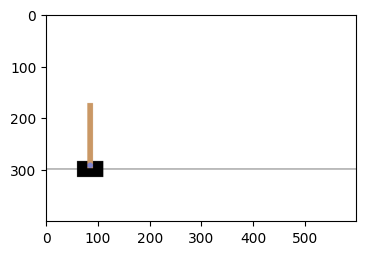

In [96]:
display_session(tmp_env, algorithm.model, t_max=10000)

#### Task 3: Implement and compare the parallelized version of the algorithm

In [123]:
from joblib import Parallel, delayed

class ParallelEvolutionManager(EvolutionManager):
    def _score(self, agent, t_max=10000, n=10, n_jobs=10):
        sample_rewards = Parallel(n_jobs=n_jobs)(
            [delayed(generate_session)(self.env, agent, t_max=t_max) for i in range(n)]
        )
        return np.mean(sample_rewards)


def _step_sample(env, model, std):
    noise = np.random.normal()
    noised_model = add_noise_to_model(
        model, 
        noise=std * noise, 
        copy=True
    )
    # assess the noised policy generating an entire sample of sessions from it
    mean_reward = score(env=env, agent=noised_model, t_max=10000)
    return noise, mean_reward

class ParallelSamplesEvolutionManager(EvolutionManager):

    def step(self):
        noise_rewards = Parallel(n_jobs=10)(
            [delayed(_step_sample)(env=self.env, std=self.std, model=self.model) for i in range(self.n_samples)]
        )
        noise = [entry[0] for entry in noise_rewards]
        rewards = [entry[1] for entry in noise_rewards]
        self.optimize(noise, rewards)
        self.update_log(rewards)

last mean reward = 594.523


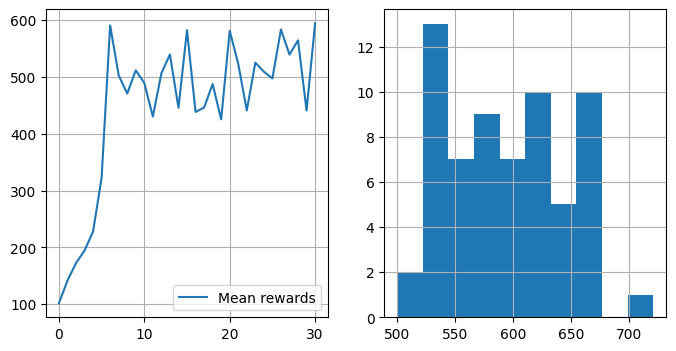

6.872746467590332


KeyboardInterrupt: 

In [21]:
# Parallelizing samles doesn't seem to affect the perfomance very much
model = MLPPolicy(n_states, n_actions)
algorithm = ParallelEvolutionManager(
    get_env_function=get_env_function,
    model=model
)

for i in range(1500):
    t = time.time()
    algorithm.step()
    print(time.time() - t)

last mean reward = 1103.744


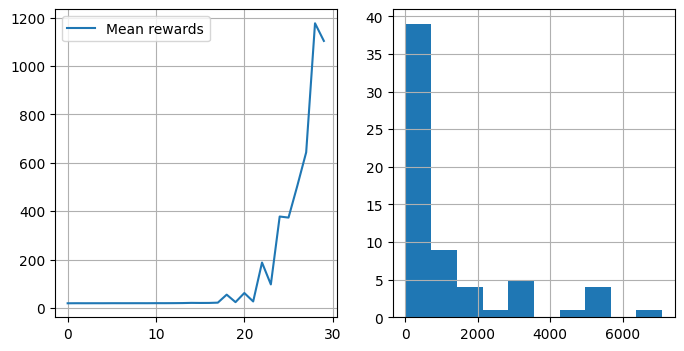

12.125759363174438


KeyboardInterrupt: 

In [124]:
# Parallelizing samles doesn't seem to affect the perfomance very much
model = MLPPolicy(n_states, n_actions)
algorithm = ParallelSamplesEvolutionManager(
    get_env_function=get_env_function,
    model=model,
    # lr=0.005,
    std=0.05
)

for i in range(1500):
    t = time.time()
    algorithm.step()
    print(time.time() - t)

Not sure whether my implementation is correst, but the training is extremely unstable. Running it multiple times yields completely different result.
Also, it seems hyperparams affect the learning dramatically

### Environment 2: LunarLanderContinuous-v2

last mean reward = 155.350


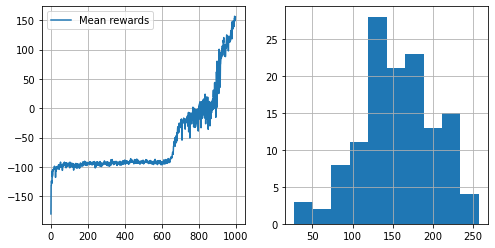

In [16]:
def get_env_function():
    env = gym.make('LunarLanderContinuous-v2').env
    return env
tmp_env = get_env_function()
n_states = tmp_env.observation_space.shape[0]
n_actions = tmp_env.action_space.shape[0]
model = <>
algorithm = <>
for i in range(1000):
    algorithm.step(model)

297.1928817226966

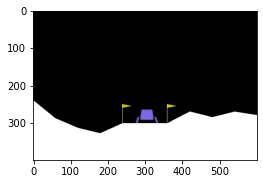

In [17]:
display_session(tmp_env, model, t_max=500)

### Task 3: Hyperparameter's analysis

Now we are going to do some experimental analysis of the algorithm.

Plan:
- to learn something about the *std* parameter
- to learn something about the *learning rate* parameter
- to learn something about the *n_samples* parameter